In [29]:
from pyropy2 import spread_model_vesta2 as v2
from pyropy2 import helpers as h
import pandas as pd
import numpy as np

from pathlib import Path
from fdrs_calcs import spread_models as sm

import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression

wet_forest = False


In [30]:
# read weather to df and rename to fdrs_calcs compatible names
test_weather_data_pth = Path('pyropy2/.data/point_forecast.csv')
df = pd.read_csv(test_weather_data_pth, 
                    header=h.find_header_row(test_weather_data_pth, 'date')
                    )

new_column_names = {
    'Temp (C)': 'air_temperature',
    'RH (%)': 'relative_humidity',
    'Wind Dir': 'wind_direction',
    'Wind Speed (km/h)': 'wind_speed',
    'Wind max in hr km/h': 'wind_speed_max',
    'Drought Factor': 'DF',
    'FBI': 'ADFD_FBI',
}

df = df.rename(columns=new_column_names)

#  create a time column
df['time'] = pd.to_datetime(df['Local Date']+ ' ' + df['Local Time'])

df.head()

C:\Users\geoffg\AppData\Local\Temp\ipykernel_27068\1225798723.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['Local Date']+ ' ' + df['Local Time'])


,Local Date,Local Time,air_temperature,relative_humidity,wind_direction,wind_speed,DF,ADFD_FBI,time
0,17-Oct-23,7:00,9.200000,69.9,216.1,11,10.0,6,2023-10-17 07:00:00
1,17-Oct-23,8:00,12.700000,58.2,213.8,13,10.0,7,2023-10-17 08:00:00
2,17-Oct-23,9:00,15.500000,49.2,196.5,15,10.0,9,2023-10-17 09:00:00
3,17-Oct-23,10:00,17.800001,40.2,183.8,16,10.0,10,2023-10-17 10:00:00
4,17-Oct-23,11:00,19.400000,35.9,171.6,18,10.0,12,2023-10-17 11:00:00


In [31]:
#  Lets make a dictionary of inputs with means and standard deviations
param_dict = {
    'wrf': (3.5, 0.5),
    'fuel_load_surface': (15, 3),
    'slope': (0, 5),
    'FHS_elevated': (3, 0.5),
    'height_elevated': (2, 0.5)    
}

for param, (m,sd) in param_dict.items():
    df[param] = np.random.normal(m,sd,df.shape[0])

df.head()

,Local Date,Local Time,air_temperature,relative_humidity,wind_direction,wind_speed,DF,ADFD_FBI,time,wrf,fuel_load_surface,slope,FHS_elevated,height_elevated
0,17-Oct-23,7:00,9.200000,69.9,216.1,11,10.0,6,2023-10-17 07:00:00,4.047368,18.715463,-1.485500,3.415256,2.839070
1,17-Oct-23,8:00,12.700000,58.2,213.8,13,10.0,7,2023-10-17 08:00:00,3.702277,13.409995,3.990435,3.410959,0.750041
2,17-Oct-23,9:00,15.500000,49.2,196.5,15,10.0,9,2023-10-17 09:00:00,4.016164,22.678726,2.656154,3.062063,1.164280
3,17-Oct-23,10:00,17.800001,40.2,183.8,16,10.0,10,2023-10-17 10:00:00,3.754642,12.033750,9.855536,3.619344,1.976825
4,17-Oct-23,11:00,19.400000,35.9,171.6,18,10.0,12,2023-10-17 11:00:00,3.805597,8.324252,-4.628814,3.805464,1.992702


In [32]:
df['height_understorey'] = v2.calc_height_understorey(df.FHS_elevated,df.height_elevated)
df.head()

,Local Date,Local Time,air_temperature,relative_humidity,wind_direction,wind_speed,DF,ADFD_FBI,time,wrf,fuel_load_surface,slope,FHS_elevated,height_elevated,height_understorey
0,17-Oct-23,7:00,9.200000,69.9,216.1,11,10.0,6,2023-10-17 07:00:00,4.047368,18.715463,-1.485500,3.415256,2.839070,1.467669
1,17-Oct-23,8:00,12.700000,58.2,213.8,13,10.0,7,2023-10-17 08:00:00,3.702277,13.409995,3.990435,3.410959,0.750041,0.464677
2,17-Oct-23,9:00,15.500000,49.2,196.5,15,10.0,9,2023-10-17 09:00:00,4.016164,22.678726,2.656154,3.062063,1.164280,0.642578
3,17-Oct-23,10:00,17.800001,40.2,183.8,16,10.0,10,2023-10-17 10:00:00,3.754642,12.033750,9.855536,3.619344,1.976825,1.066037
4,17-Oct-23,11:00,19.400000,35.9,171.6,18,10.0,12,2023-10-17 11:00:00,3.805597,8.324252,-4.628814,3.805464,1.992702,1.084825


In [33]:
df['fuel_moisture'] = sm.dry_forest.fuel_moisture_model(
        df.air_temperature,
        df.relative_humidity,
        (df.time.dt.month,df.time.dt.hour),
        wet_forest=wet_forest
    )

df['fuel_availability'] = v2.calc_fuel_availability(df.DF, wet_forest=wet_forest)

df['ros_phase1'] = v2.calc_ros_phase1(
    df.wind_speed, df.fuel_moisture, df.fuel_availability, df.fuel_load_surface, df.wrf, slope = df.slope
    )

df['ros_phase2'] = v2.calculate_ros_phase2(
    df.wind_speed, df.fuel_moisture, df.fuel_availability, df.fuel_load_surface, df.wrf, df.height_understorey, slope = df.slope
    )

df['ros_phase3'] = v2.calc_ros_phase3(df.wind_speed, df.fuel_moisture, df.fuel_availability)

df['probability_phase2'] = v2.calc_probability_phase2(
    df.wind_speed, df.fuel_moisture, df.fuel_availability, df.fuel_load_surface, df.wrf
    )

df['probability_phase3'] = v2.calc_probability_phase3(df.wind_speed, df.fuel_moisture, df.fuel_availability, df.ros_phase2)

df['ROS'] = v2.calc_rate_of_spread(
    df.ros_phase1, df.ros_phase2, df.ros_phase3, df.probability_phase2, df.probability_phase3
    )

df.head()

,Local Date,Local Time,air_temperature,relative_humidity,wind_direction,wind_speed,DF,ADFD_FBI,time,wrf,...,height_elevated,height_understorey,fuel_moisture,fuel_availability,ros_phase1,ros_phase2,ros_phase3,probability_phase2,probability_phase3,ROS
0,17-Oct-23,7:00,9.200000,69.9,216.1,11,10.0,6,2023-10-17 07:00:00,4.047368,...,2.839070,1.467669,14.9991,0.998481,34.514090,149.932620,206.870374,0.779940,0.000000e+00,124.533662
1,17-Oct-23,8:00,12.700000,58.2,213.8,13,10.0,7,2023-10-17 08:00:00,3.702277,...,0.750041,0.464677,12.8643,0.998481,74.230419,179.821267,349.480238,0.200883,0.000000e+00,95.441837
2,17-Oct-23,9:00,15.500000,49.2,196.5,15,10.0,9,2023-10-17 09:00:00,4.016164,...,1.164280,0.642578,11.2173,0.998481,138.645755,344.722601,551.855995,0.999887,5.992046e-08,344.699297
3,17-Oct-23,10:00,17.800001,40.2,183.8,16,10.0,10,2023-10-17 10:00:00,3.754642,...,1.976825,1.066037,9.5928,0.998481,221.577290,792.157339,780.374708,0.803909,2.616458e-06,680.271925
4,17-Oct-23,11:00,19.400000,35.9,171.6,18,10.0,12,2023-10-17 11:00:00,3.805597,...,1.992702,1.084825,8.7941,0.998481,85.854279,327.851265,1013.290413,0.383926,3.133612e-05,178.763203


In [34]:
param_names = {
    'wind_speed': '10m wind speed (km/h)',
    'fuel_moisture': 'Fuel Moisture Content %',
    'wrf': 'Wind Reduction Factor',
    'fuel_load_surface': 'Surface plus near-surface fuel load (t/ha)',
    'FHS_elevated': 'elevated fuel hazard score',
    'height_elevated': 'elevated fuel height (m)',
    'height_understorey': 'understorey fuel height (m)',
    'ADFD_FBI': 'Fire Behaviour Index from AFDF',
}

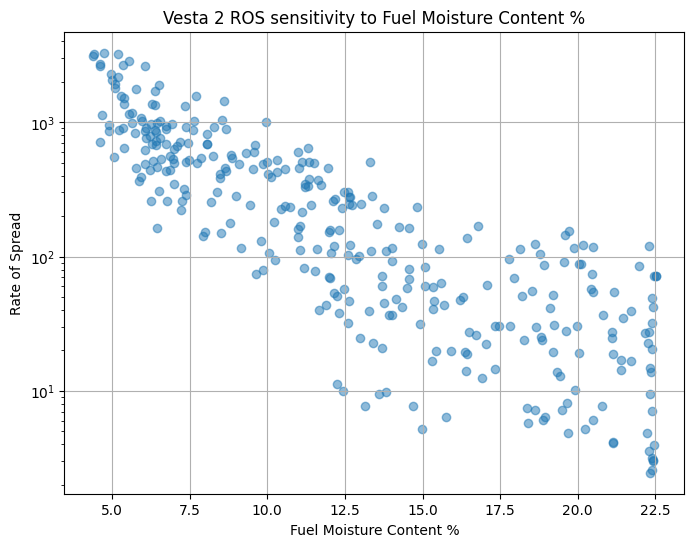

In [35]:
param = 'fuel_moisture'
plt.figure(figsize=(8, 6))
plt.scatter(df[param], df['ROS'], alpha=0.5)
plt.title(f'Vesta 2 ROS sensitivity to {param_names[param]}')
plt.xlabel(param_names[param])
plt.ylabel('Rate of Spread')
plt.grid(True)
plt.yscale('log')
plt.show()


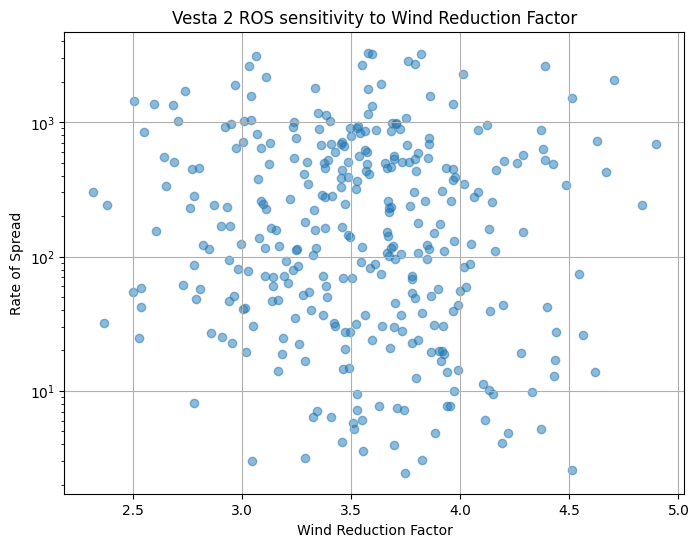

In [36]:
param = 'wrf'
plt.figure(figsize=(8, 6))
plt.scatter(df[param], df['ROS'], alpha=0.5)
plt.title(f'Vesta 2 ROS sensitivity to {param_names[param]}')
plt.xlabel(param_names[param])
plt.ylabel('Rate of Spread')
plt.grid(True)
plt.yscale('log')
plt.show()

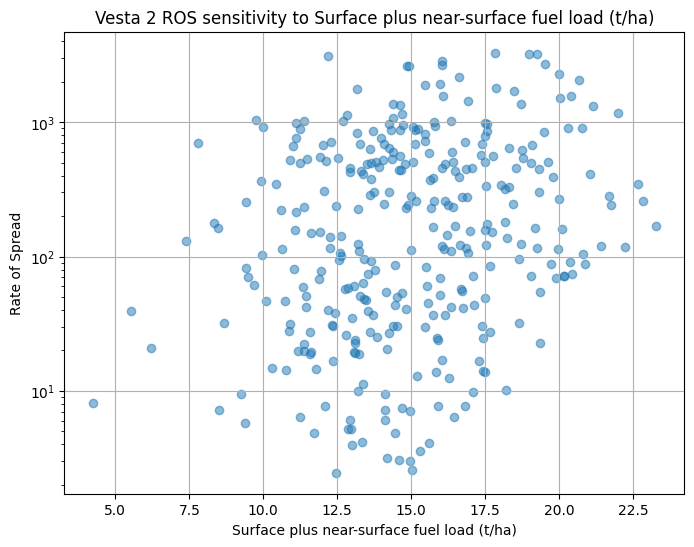

In [49]:
param = 'fuel_load_surface'
plt.figure(figsize=(8, 6))
plt.scatter(df[param], df['ROS'], alpha=0.5)
plt.title(f'Vesta 2 ROS sensitivity to {param_names[param]}')
plt.xlabel(param_names[param])
plt.ylabel('Rate of Spread')
plt.grid(True)
plt.yscale('log')
plt.show()

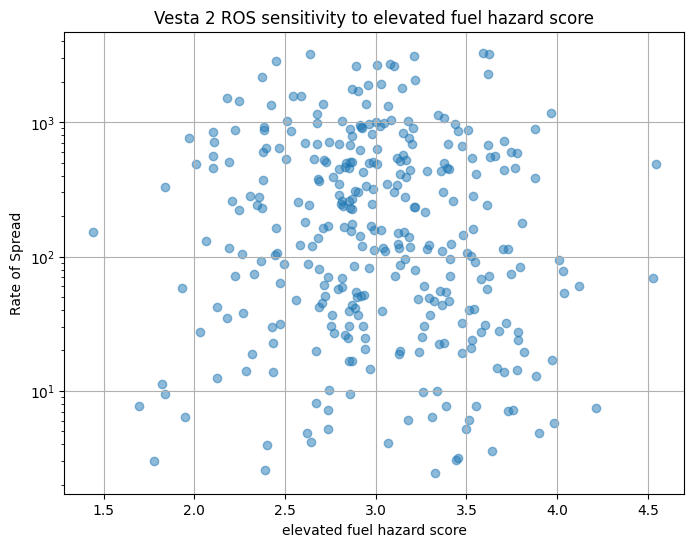

In [38]:
param = 'FHS_elevated'
plt.figure(figsize=(8, 6))
plt.scatter(df[param], df['ROS'], alpha=0.5)
plt.title(f'Vesta 2 ROS sensitivity to {param_names[param]}')
plt.xlabel(param_names[param])
plt.ylabel('Rate of Spread')
plt.grid(True)
plt.yscale('log')
plt.show()



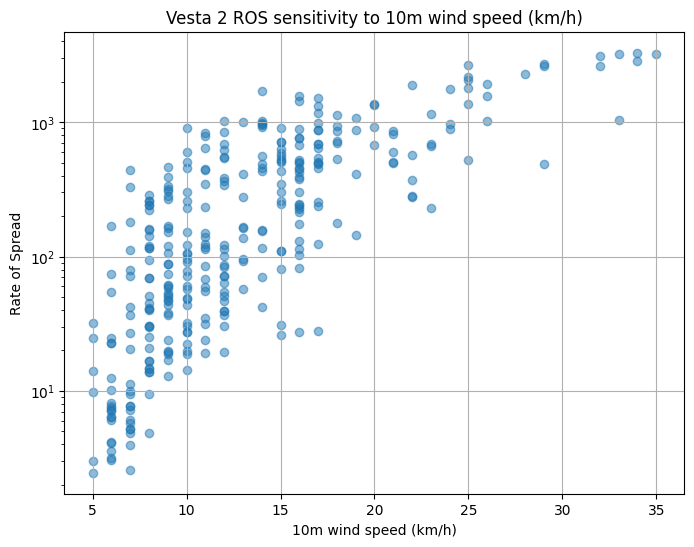

In [39]:
param = 'wind_speed'
plt.figure(figsize=(8, 6))
plt.scatter(df[param], df['ROS'], alpha=0.5)
plt.title(f'Vesta 2 ROS sensitivity to {param_names[param]}')
plt.xlabel(param_names[param])
plt.ylabel('Rate of Spread')
plt.grid(True)
plt.yscale('log')
plt.show()

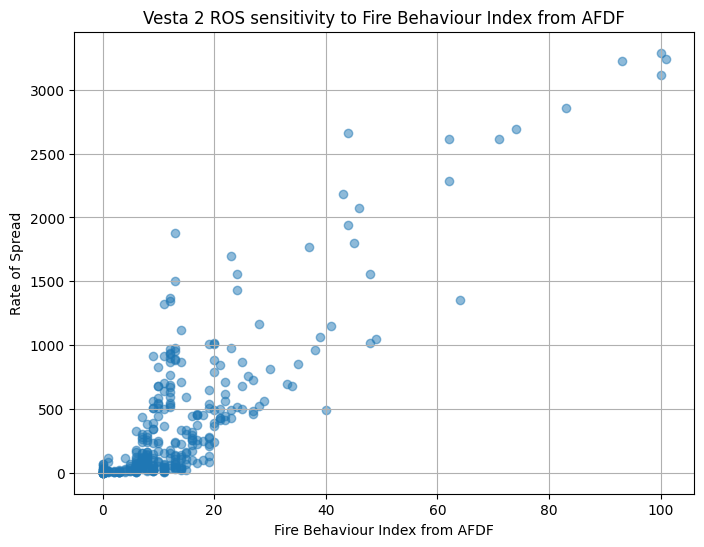

In [43]:
param = 'ADFD_FBI'
plt.figure(figsize=(8, 6))
plt.scatter(df[param], df['ROS'], alpha=0.5)
plt.title(f'Vesta 2 ROS sensitivity to {param_names[param]}')
plt.xlabel(param_names[param])
plt.ylabel('Rate of Spread')
plt.grid(True)
# plt.yscale('log')
plt.show()

In [47]:
for param, description in param_names.items():
    # Calculate Pearson correlation coefficient
    pearson_corr = round(df['ROS'].corr(df[param]),2)

    # Calculate Spearman's rank correlation coefficient
    spearman_corr = round(spearmanr(df['ROS'], df[param])[0],2)

    # Calculate mutual information
    mutual_info = round(mutual_info_regression(df[['ROS']], df[param])[0],2)

    print(f'{description}:\n pearson = {pearson_corr}\n spearman = {spearman_corr}\n mutual info = {mutual_info}')

10m wind speed (km/h):
 pearson = 0.79
 spearman = 0.77
 mutual info = 0.58
Fuel Moisture Content %:
 pearson = -0.65
 spearman = -0.87
 mutual info = 0.66
Wind Reduction Factor:
 pearson = -0.02
 spearman = -0.09
 mutual info = 0.03
Surface plus near-surface fuel load (t/ha):
 pearson = 0.2
 spearman = 0.24
 mutual info = 0.04
elevated fuel hazard score:
 pearson = -0.04
 spearman = -0.1
 mutual info = 0.01
elevated fuel height (m):
 pearson = 0.06
 spearman = 0.05
 mutual info = 0.0
understorey fuel height (m):
 pearson = 0.05
 spearman = 0.04
 mutual info = 0.03
Fire Behaviour Index from AFDF:
 pearson = 0.86
 spearman = 0.76
 mutual info = 0.79


In [41]:
df.shape

(327, 23)